## 이미지 식별을 위한 라이브러리를 불러온다.

In [6]:
import matplotlib.pyplot as plt # 데이터 플로팅 라이브러리
import numpy as np # 숫자 처리 라이브러리
import torch # 딥러닝을 위한 파이토치 라이브러리
from torch import nn, optim
import torchvision # 토치비전 라이브러리
from torchvision import datasets, transforms, models
from PIL import Image # 이미지 처리 라이브러리

# 주피터 노트북에서 plot이 보이도록 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import random # 난수 생성 라이브러리

# 시드 설정 함수
def set_seed(seed):
  torch.manual_seed(seed) # PyTorch CPU 연산을 위한 시드 설정
  if torch.cuda.is_available(): # PyTorch GPU 연산을 위한 시드 설정
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # 모든 GPU에 시드 설정
  np.random.seed(seed) # NumPy 연산을 위한 시드 설정
  random.seed(seed) # Python 내장 random 모듈을 위한 시드 설정

  # CuDNN 결정론적 동작 설정 (GPU 사용 시 추가적으로 재현성을 높임)
  # CuDNN 백엔드가 결정론적으로 동작하도록 설정합니다. 이는 일부 연산에서 속도 최적화를 위해
  # 비결정론적인 알고리즘을 사용할 수 있는데, 이를 방지하여 항상 동일한 결과를 얻도록 합니다.
  # 단, 이 설정은 성능에 영향을 줄 수 있습니다.
  torch.backends.cudnn.daterministic = True 
  torch.backends.cudnn.benchmark = False

# 시드 설정
set_seed(42) # 원하는 시드 값 설정

### 데이터 디렉토리, 분할 비율, 변환 방법을 설정한다.

In [11]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(valid_size)을 설정한다.
data_dir = 'data'
valid_size = 0.2

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### 코드들을 묶어서 load_split_train_test() 함수를 만든다.

In [12]:
# 위의 코드를 묶어서 load_split_train_test 함수로 정의한다.
def load_split_train_test(data_dir, valid_size):
    train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

### load_split_train_test() 함수를 이용하여 trainloader, testloader를 생성한다.

In [13]:
# load_split_train_test 함수를 호출하여 학습 데이터와 테스트 데이터를 불러온다.
trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


In [14]:
def denormalize(tensor):
    """텐서를 정규화된 상태에서 원래 이미지로 되돌린다."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

### 이미지 데이터 샘플들을 살펴본다.

임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_images() 함수를 만든다.

In [15]:
def get_random_images(num, transforms):
    data = datasets.ImageFolder(data_dir, transform=transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    # loader에서 데이터를 한 개씩 꺼내 주는 iterator를 생성한다.
    dataiter = iter(loader)
    images, labels = next(dataiter)

    return images, labels

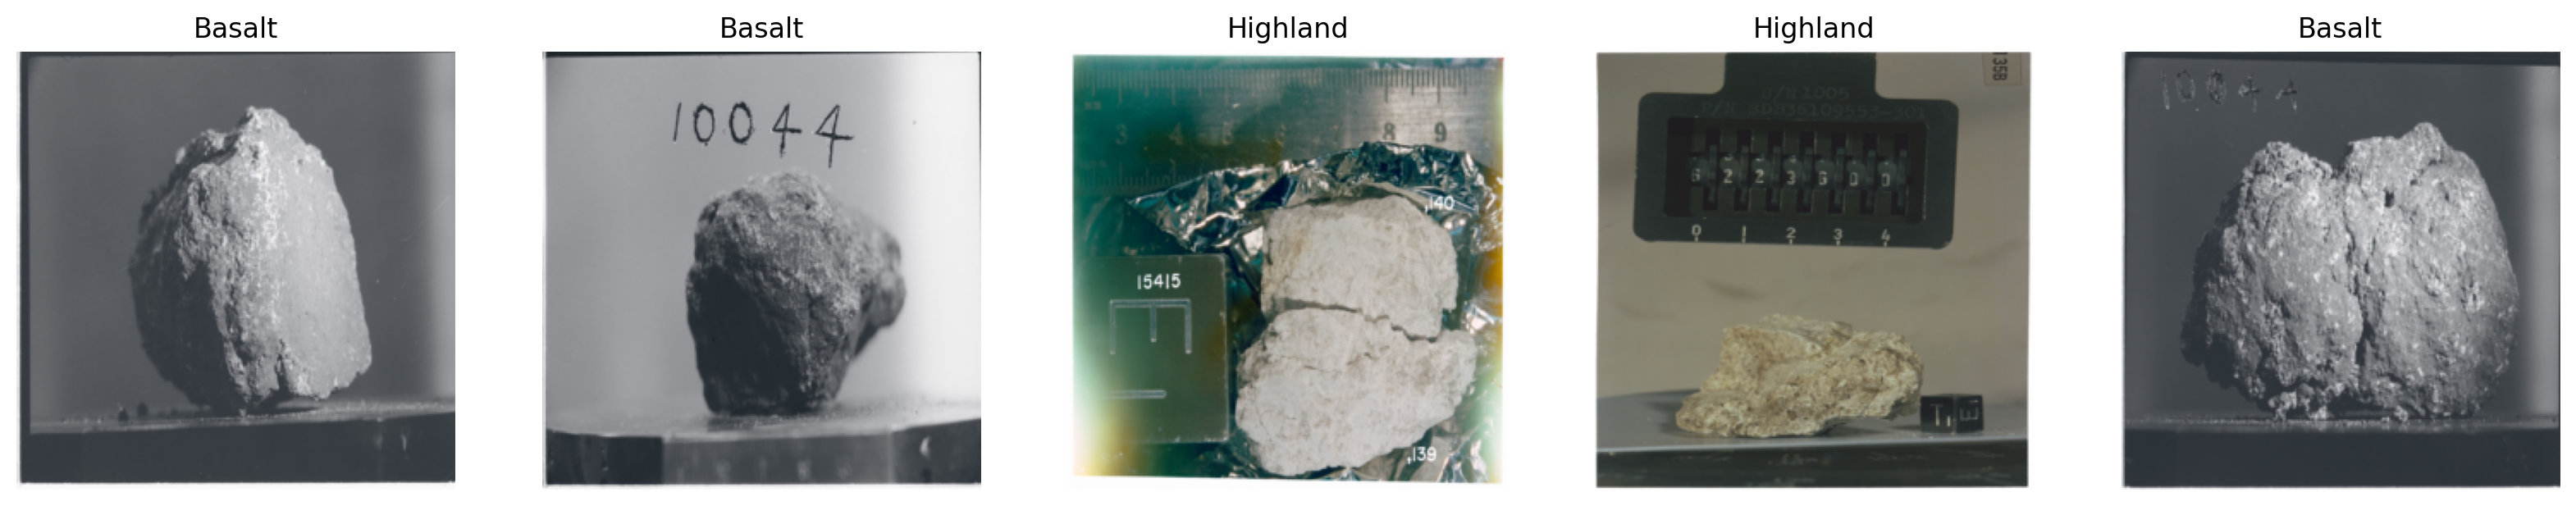

In [16]:
unnormalized_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5, unnormalized_transforms)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))
# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes
# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
# 주피터 노트북에 이미지를 표시한다.
plt.show()

### ResNet50 모델을 가져와 FCL(Fully Connected Layer)을 수정한다.

Compute device를 정한다(CPU or GPU)

In [17]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### 사전 학습된 ResNet50 모델을 지정한다.

In [18]:
# resnet50 모델을 불러오고, 사전 훈련된 가중치를 사용한다.
model = models.resnet50(pretrained=True)

/workspaces/spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### (확인) 수정 전의 ResNet50 모델을 확인해 본다.

In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze하고 마지막 레이어를 수정한다.
for param in model.parameters():
    param.requires_grad = False
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 2),
                         nn.LogSoftmax(dim=1))
# 손실 함수와 최적화 알고리즘을 설정한다.
criterion = nn.NLLLoss()
# 최적화 알고리즘은 Adam으로 설정하고, 학습률은 0.003으로 설정한다.
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
# 모델을 compute device로 이동시킨다.
model.to(device)
# 종료 여부를 출력한다.
print('done!')

done!


### (확인) FCL을 확인해 본다.

In [21]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


### 모델의 FCL을 학습시키고 테스트 한다.

모델 학습/검증을 위한 변수를 설정한다.

In [22]:
# 에폭 및 출력 주기를 설정한다.
epochs = 10
print_every = 5
# 손실 변수와 학습 및 테스트 손실을 초기화한다.
running_loss = 0
train_losses, test_losses = [], []
# 현재의 학습 단계를 표현하는 STEPS 변수를 0으로 초기화한다.
steps = 0

In [23]:
# 설정한 회수만큼 학습 후 검증한다.
for epoch in range(epochs) :
    # trainloader에서 데이터를 가져와서 학습을 진행한다.
    for inputs, labels in trainloader:
        # 학습 단계를 증가시키고, 현재 학습 단계를 출력한다.
        steps += 1
        print('Training step ', steps)

        # 입력 데이터와 레이블을 compute device로 이동시킨다.
        inputs, labels = inputs.to(device), labels.to(device)

        # 기존에 학습된 gradient 값을 초기화 한다.(이전에 학습한 값이 영향을 주지 않도록 함)
        optimizer.zero_grad()
        # 입력 데이터로 순전파를 수행하고 로그 확률을 계산한다.
        logps = model.forward(inputs)
        # 손실 함수를 사용하여 손실을 계산한다.
        loss = criterion(logps, labels)
        # 손실값을 기준으로 gradient를 계산한다.
        loss.backward()
        # 최적화 알고리즘을 이용하여 가중치를 업데이트한다.
        optimizer.step()
        # 현재 학습 단계의 손실값을 누적한다.
        running_loss += loss.item()

        # 현재 학습 단계를 출력한다.
        if steps % print_every == 0:
            # 현재 학습 단계의 손실값을 출력한다.
            test_loss = 0.0
            # 테스트 데이터에 대한 손실값과 정확도를 계산한다.
            accuracy = 0.0
            # 모델 평가 모드로 전환한다. (드롭아웃 등을 비활성화)
            model.eval()
            # 모델 평가 시 gradient를 계산하지 않도록 한다.
            with torch.no_grad():
                # testloader에서 이미지와 레이블을 하나씩 가져온다.
                for inputs, labels in testloader:
                    # 입력 데이터(이미지, 레이블)을 device로 이동시킨다.
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
                    logps = model.forward(inputs)
                    # 손실함수로 손실(loss) 값을을 계산한다.
                    batch_loss = criterion(logps, labels)
                    # 손실값을 누적시킨다.
                    test_loss += batch_loss.item()
                    # 로그 확률을 실제 확률값으로 변환한다.
                    ps = torch.exp(logps)
                    # 가장 큰 확률값을 갖는 클래스를 선택한다.
                    top_p, top_class = ps.topk(1, dim=1)
                    # 정답 레이블들을 top_class와 비교하여 정확도를 계산한다.
                    equals = top_class == labels.view(*top_class.shape)
                    # equals의 평균을 계산하여 정확도를 누적한다.
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # 학습 손실값과 테스트 손실값을 리스트에 추가한다.
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도를 출력한다.
            print("Epoch {}/{}: ".format(epoch+1, epochs),
                "Train loss: {:.3f}.. ".format(running_loss/print_every),
                "Test loss: {:.3f}.. ".format(test_loss/len(testloader)),
                "Test accuracy: {:.3f}\n".format(accuracy/len(testloader)))
            
            # print_every마다 running_loss를 초기화한다.
            running_loss = 0.0
            # 모델을 학습 모드로 전환한다.
            model.train()
            
            break

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/10:  Train loss: 2.947..  Test loss: 1.457..  Test accuracy: 0.354

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/10:  Train loss: 0.872..  Test loss: 0.630..  Test accuracy: 0.644

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 3/10:  Train loss: 0.867..  Test loss: 0.513..  Test accuracy: 0.642

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 4/10:  Train loss: 0.391..  Test loss: 0.436..  Test accuracy: 0.871

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 5/10:  Train loss: 0.442..  Test loss: 0.412..  Test accuracy: 0.808

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 6/10:  Train loss: 0.393..  Test loss: 0.391..  Test accuracy: 0.873

Training step

### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인한다.

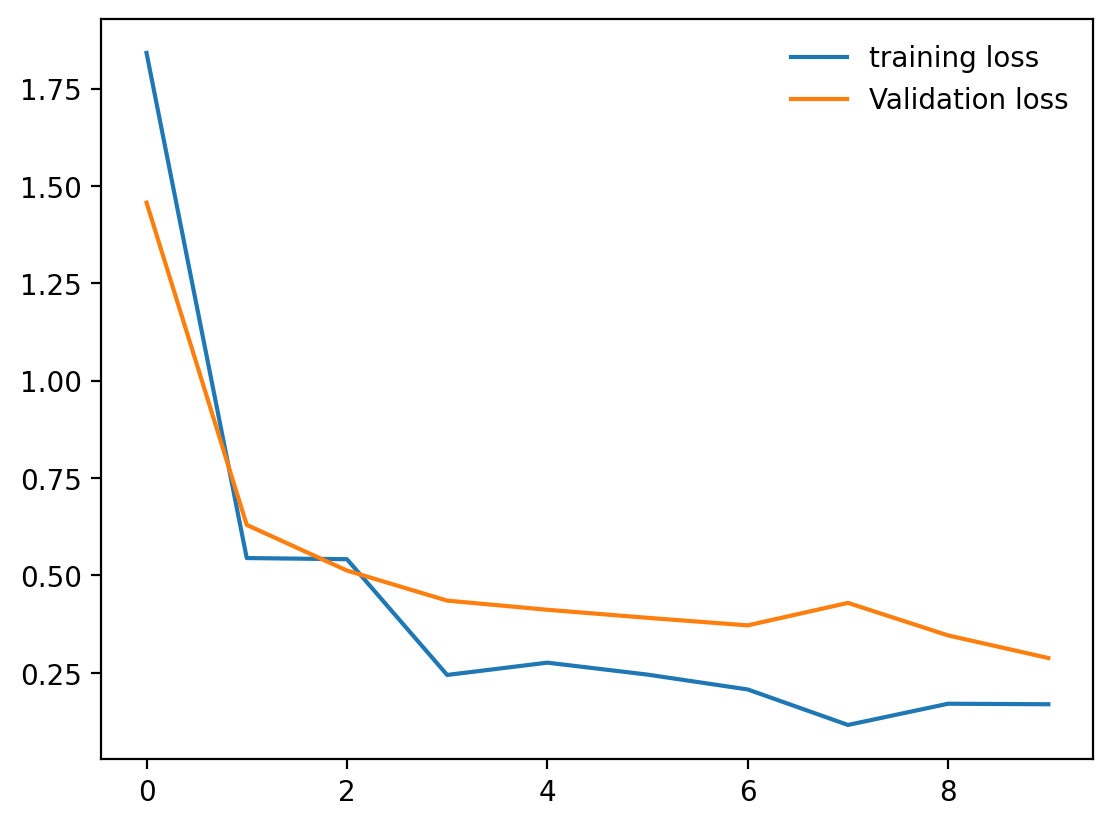

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 학습/테스트 완료된 모델을 저장한다.

In [30]:
# 나중에 모델을 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.
torch.save(model, 'moonrockmodel.pth')

### 완성된 모델을 사용하여 예측한다.

저장한 모델을 불러온다.

In [31]:
# 저장한 모델을 불러온다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

### (확인) 불러온 모델을 확인해 본다.

In [32]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 이미지 예측을 위해 predict_image() 함수를 만든다.

In [35]:
def predict_image(image, test_transforms):
    image_tensor = test_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

### 5개의 이미지를 임의로 가져와 예측해 본다.

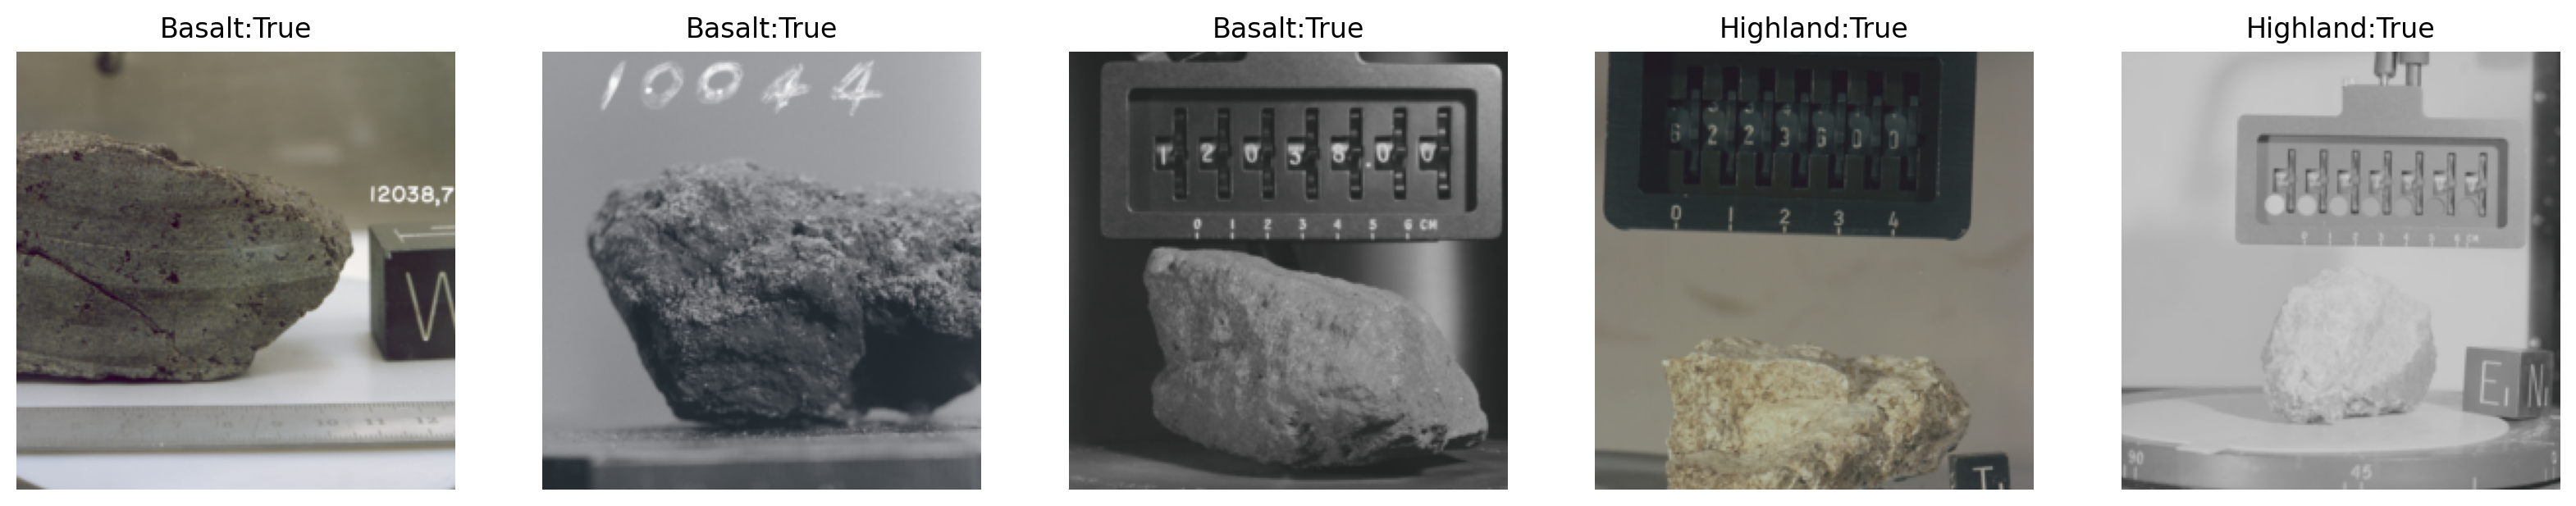

In [36]:
# 모델 평가 모드로 전환한다.
model.eval()
# 5개의 이미지를 랜덤하게 가져온 후 pil 형식 변환, 표시할 이미지 크기를 설정한다.
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5, test_transforms)
fig = plt.figure(figsize=(20, 20))
# 데이터의 classes를 가져온다.
classes = trainloader.dataset.classes

# 5개의 이미지에 대해 반복을 수행한다.
for ii in range(len(images)):
    image_tensor_cpu = images[ii].cpu()
    denormalized_image = denormalize(image_tensor_cpu.clone())
    denormalized_image = torch.clamp(denormalized_image, 0, 1)
    # 각 이미지에 대해 예측을 수행한다.
    image = to_pil(denormalized_image)
    index= predict_image(image, test_transforms)
    # 이미지 아래에 class 이름과 예측 결과를 표시한다.
    sub = fig.add_subplot(1, len(images), ii+1)
    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)
    # 레이블이 추가된 이미지를 표시한다.
plt.show()